In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.decomposition import PCA
from plotly.subplots import make_subplots

In [ ]:
def preprocess_data(df, features):
    X = df[features].copy()
    for col in X.select_dtypes(include=['object']).columns:
        X[col] = X[col].astype(str)
    num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = X.select_dtypes(include=['object']).columns.tolist()

    numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
    categorical_transformer = Pipeline(steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_cols),
            ("cat", categorical_transformer, cat_cols),
        ]
    )
    return preprocessor.fit_transform(X)

In [ ]:
def treat_outliers(
    df: pd.DataFrame,
    cols: list,
    method: str = "iqr",          # "iqr" ou "zscore"
    strategy: str = "winsorize",  # "winsorize" (cap/clip) ou "remove"
    factor: float = 1.5,          # multiplicador do IQR (1.5 padrão)
    z: float = 4.0,               # limiar de z-score se method="zscore"
    return_info: bool = True
):

    df_out = df.copy()
    info = {"limits": {}, "n_capped": {}, "n_removed": 0}

    # Calcula limites por coluna
    limits = {}
    for c in cols:
        s = df_out[c].astype(float)
        if method == "iqr":
            q1, q3 = s.quantile(0.25), s.quantile(0.75)
            iqr = q3 - q1
            low, high = q1 - factor * iqr, q3 + factor * iqr
        elif method == "zscore":
            mu, sd = s.mean(), s.std(ddof=0)
            low, high = mu - z * sd, mu + z * sd
        else:
            raise ValueError("method deve ser 'iqr' ou 'zscore'")
        limits[c] = (low, high)

    if strategy == "remove":

        mask = np.ones(len(df_out), dtype=bool)
        for c, (low, high) in limits.items():
            mask &= df_out[c].between(low, high) | df_out[c].isna()
        info["n_removed"] = int((~mask).sum())
        df_out = df_out[mask].reset_index(drop=True)
    elif strategy == "winsorize":
        # Faz clip por coluna
        for c, (low, high) in limits.items():
            before = df_out[c].copy()
            df_out[c] = df_out[c].clip(lower=low, upper=high)
            info["n_capped"][c] = int((before != df_out[c]).sum())
    else:
        raise ValueError("strategy deve ser 'winsorize' ou 'remove'")

    if return_info:
        info["limits"] = limits
        return df_out, info
    return df_out

In [ ]:
def run_kmeans(X_proc, k_values=range(2, 11)):

    sils = []
    models = []
    for k in k_values:
        km = MiniBatchKMeans(n_clusters=k, batch_size=1024, random_state=42)
        labels = km.fit_predict(X_proc)
        score = silhouette_score(X_proc, labels, sample_size=min(10000, X_proc.shape[0]), random_state=42)
        sils.append(score)
        models.append((km, labels))
    idx = int(np.argmax(sils))
    best_model, best_labels = models[idx]
    return best_labels, k_values[idx], sils[idx], best_model

In [ ]:
def add_clusters_to_df(df, labels, cluster_col="cluster"):
    df_out = df.copy()
    df_out[cluster_col] = labels
    return df_out

In [ ]:
def run_hierarchical_select_k(df_work, features, k=4, k_values=range(2, 11)):

    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(df_work[features])


    Z = linkage(X_scaled, method="ward", metric="euclidean")


    if k is not None:
        labels = fcluster(Z, t=k, criterion="maxclust")
        if len(np.unique(labels)) >= 2:
            score = silhouette_score(X_scaled, labels)
        else:
            score = -1  # Caso degenerado (apenas 1 cluster)
        return labels, k, score, Z, X_scaled

    best_k, best_score, best_labels = None, -1, None
    for k in k_values:
        labels = fcluster(Z, t=k, criterion="maxclust")

        if len(np.unique(labels)) >= 2 and len(np.unique(labels)) < len(labels):
            score = silhouette_score(X_scaled, labels)
            if score > best_score:
                best_k, best_score, best_labels = k, score, labels

    return best_labels, best_k, best_score, Z, X_scaled

In [ ]:
def merge_back(original_df, df_work, labels, cluster_col, fill_value=-1):

    assert len(df_work) == len(labels), "Comprimento de labels difere do df usado no fit."
    res = df_work[["row_id"]].copy()
    res[cluster_col] = labels
    out = original_df.merge(res, on="row_id", how="left")
    if fill_value is not None:
        out[cluster_col] = out[cluster_col].fillna(fill_value).astype(int)
    return out

In [ ]:
file_path = "../artifacts/synthetic_personal_finance_dataset.csv"
df = pd.read_csv(file_path)
df['loan_type'] = df['loan_type'].fillna('None')

# **Feature Engineering**

In [ ]:
df['high_risk_debt'] = np.where(df['debt_to_income_ratio'] > 0.4, 1, 0)
df['savings_alert'] = np.where(df['savings_to_income_ratio'] < 0.2, 1, 0)
df['emi_crisis'] = np.where(df['monthly_emi_usd'] > (df['monthly_income_usd'] * 0.3), 1, 0)

In [ ]:
variaveis_cluster = [
    'monthly_income_usd',
    'savings_to_income_ratio',
    'debt_to_income_ratio',
    'loan_amount_usd',
    'credit_score',
    'employment_status',
    'education_level',
    'high_risk_debt',
    'emi_crisis'
]

# Tratamento de **Outliers**

In [ ]:
num_for_outliers = [
    'monthly_income_usd',
    'savings_to_income_ratio',
    'debt_to_income_ratio',
    'loan_amount_usd',
    'credit_score'
]

In [ ]:
df_work = df.copy()  # mantém todas as colunas
df_work, out_info = treat_outliers(
    df_work,
    cols=num_for_outliers,
    method="iqr",
    strategy="remove",
    factor=1.5,
)

df_work = df_work.reset_index(drop=True)

In [ ]:
print("[Outliers] Limites por coluna:")
for c, (lo, hi) in out_info["limits"].items():
    print(f"  - {c}: [{lo:.4f}, {hi:.4f}]  | capped={out_info['n_capped'].get(c, 0)}")


[Outliers] Limites por coluna:
  - monthly_income_usd: [-1382.9237, 9392.3263]  | capped=0
  - savings_to_income_ratio: [-4.8150, 14.9050]  | capped=0
  - debt_to_income_ratio: [-1.3800, 2.3000]  | capped=0
  - loan_amount_usd: [-284248.6050, 473747.6750]  | capped=0
  - credit_score: [21.5000, 1129.5000]  | capped=0


In [ ]:
features_kmeans = [
    "monthly_income_usd",
    "savings_to_income_ratio",
    "debt_to_income_ratio",
    "loan_amount_usd",
    "credit_score",
    "employment_status",
    "education_level",
    "high_risk_debt",
    "emi_crisis",
]
features_hier = [
    "monthly_income_usd",
    "savings_to_income_ratio",
    "debt_to_income_ratio",
    "loan_amount_usd",
    "credit_score",
    "high_risk_debt",
    "emi_crisis",
    "savings_alert",
]

# **KMeans**

In [ ]:
X_km = preprocess_data(df_work, features_kmeans)
labels_km, best_k_km, sil_km, _ = run_kmeans(X_km, k_values=range(2, 11))
print(f"[KMeans] Melhor k = {best_k_km} | Silhueta = {sil_km:.3f}")

[KMeans] Melhor k = 2 | Silhueta = 0.441


# **Clusterização Hierárquica**

In [ ]:
labels_hier, best_k_hier, sil_hier, Z, X_hier = run_hierarchical_select_k(df_work,features_hier,4)
df["cluster_hier"] = -1
df.loc[df_work.index, "cluster_hier"] = labels_hier
print(f"[Hierárquico] Melhor k = {best_k_hier} | Silhueta = {sil_hier:.3f}")

[Hierárquico] Melhor k = 4 | Silhueta = 0.501


# **Visualizações**

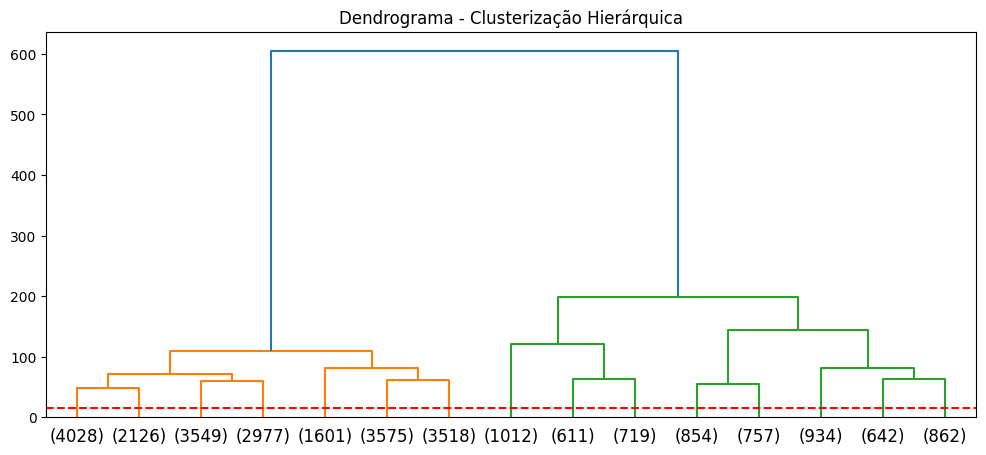

In [ ]:
plt.figure(figsize=(12, 5))
plt.title("Dendrograma - Clusterização Hierárquica")
dendrogram(Z, truncate_mode='lastp', p=15, show_leaf_counts=True)
plt.axhline(y=15, color='r', linestyle='--')
plt.show()

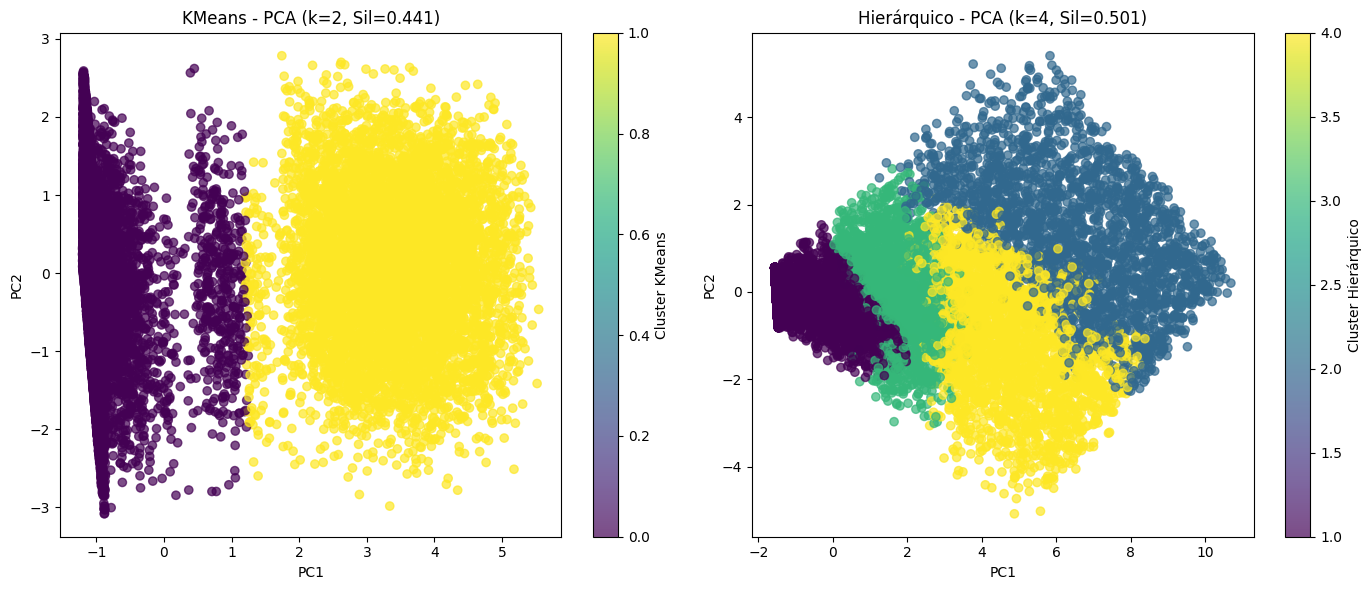

In [ ]:
pca = PCA(n_components=2)
X_km_pca = pca.fit_transform(X_km)
X_hier_pca = pca.fit_transform(X_hier)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sc1 = axes[0].scatter(X_km_pca[:, 0], X_km_pca[:, 1], c=labels_km, cmap="viridis", alpha=0.7)
axes[0].set_title(f"KMeans - PCA (k={best_k_km}, Sil={sil_km:.3f})")
axes[0].set_xlabel("PC1"); axes[0].set_ylabel("PC2")
plt.colorbar(sc1, ax=axes[0], label="Cluster KMeans")

sc2 = axes[1].scatter(X_hier_pca[:, 0], X_hier_pca[:, 1], c=labels_hier, cmap="viridis", alpha=0.7)
axes[1].set_title(f"Hierárquico - PCA (k={best_k_hier}, Sil={sil_hier:.3f})")
axes[1].set_xlabel("PC1"); axes[1].set_ylabel("PC2")
plt.colorbar(sc2, ax=axes[1], label="Cluster Hierárquico")

plt.tight_layout()
plt.show()




In [ ]:
def simple_cluster_count(df, cluster_col):

    count = df[cluster_col].value_counts().sort_index()
    percent = (df[cluster_col].value_counts(normalize=True) * 100).sort_index().round(2)

    return pd.DataFrame({
        'Cluster': count.index,
        'Count': count.values,
        'Percentage': percent.values
    })

hier_counts = simple_cluster_count(df, 'cluster_hier')


print("\nContagem Hierárquico:")
print(hier_counts)


Contagem Hierárquico:
   Cluster  Count  Percentage
0       -1   4659       14.37
1        1  21374       65.92
2        2   2342        7.22
3        3   1611        4.97
4        4   2438        7.52


In [ ]:
cluster_des = df[df['cluster_hier'] != -1].copy()

In [ ]:

import openpyxl
from openpyxl.styles import Alignment, Font


colunas_novas = {
    "monthly_income_usd": "Renda Mensal (USD)",
    "loan_amount_usd": "Valor Empréstimo (USD)",
    "debt_to_income_ratio": "Razão Dívida/Renda",
    "credit_score": "Score de Crédito",
    "savings_usd": "Economias (USD)",
    "savings_to_income_ratio": "Proporção Economia/Renda Anual",
    "monthly_expenses_usd": "Gastos Mensais (USD)",
    "loan_interest_rate_pct": "Taxa Juros (%)",
    "monthly_emi_usd": "Prestação Mensal (USD)",
    "loan_term_months": "Prazo Empréstimo (meses)",
    "age": "Idade",
    "gender": "Gênero",
    "education_level": "Escolaridade",
    "employment_status": "Situação Emprego",
    "job_title": "Cargo",
    "loan_type": "Tipo de Empréstimo",
    "region": "Região"
}


cluster_des.rename(columns=colunas_novas, inplace=True)

def format_value(x):
    if isinstance(x, (int, float)):
        if abs(x) >= 1000:
            return f"{x:,.0f}"
        elif 0 < abs(x) < 1:
            return f"{x:.2%}" if '%' in str(x) else f"{x:.4f}"
        else:
            return f"{x:.2f}"
    return x


writer = pd.ExcelWriter('Perfis_de_Cluster.xlsx', engine='openpyxl')


cluster_des.to_excel(writer, sheet_name='Dados Completos', index=False)


perfis = {}
for cluster_id, grupo in cluster_des.groupby("cluster_hier"):
  
    estatisticas = grupo.describe(include='number').transpose()[['mean', 'std', 'min', 'max', '50%']]
    estatisticas.rename(columns={'50%': 'mediana'}, inplace=True)
    estatisticas = estatisticas.applymap(format_value)


    categoricas = pd.DataFrame()
    for col in ["Gênero", "Escolaridade", "Situação Emprego", "Cargo", "Tipo de Empréstimo", "Região"]:
        if col in grupo.columns:
            temp = grupo[col].value_counts(normalize=True).reset_index()
            temp.columns = [col, 'Proporção']
            temp['Proporção'] = temp['Proporção'].apply(lambda x: f"{x:.1%}")
            categoricas = pd.concat([categoricas, temp], axis=0)

   
    insights_data = {
        "Métrica": [
            "Média de renda",
            "Score de crédito médio",
            "Razão dívida/renda média",
            "% com empréstimo",
            "Idade média",
            "Proporção Economia/Renda média"
        ],
        "Valor": [
            f"${grupo['Renda Mensal (USD)'].mean():,.2f}",
            f"{grupo['Score de Crédito'].mean():.0f}",
            f"{grupo['Razão Dívida/Renda'].mean():.2f}",
            f"{grupo['Tipo de Empréstimo'].notna().mean()*100:.1f}%",
            f"{grupo['Idade'].mean():.1f} anos",
            f"{grupo['Proporção Economia/Renda Anual'].mean():.2f}"
        ]
    }
    insights_df = pd.DataFrame(insights_data)

   
    sheet_name = f'Cluster_{cluster_id}'

    estatisticas.to_excel(writer, sheet_name=sheet_name, startrow=1)
    categoricas.to_excel(writer, sheet_name=sheet_name, startrow=len(estatisticas)+4)
    insights_df.to_excel(writer, sheet_name=sheet_name, startrow=len(estatisticas)+len(categoricas)+8)


    workbook = writer.book
    worksheet = writer.sheets[sheet_name]


    worksheet['A1'] = f"Perfil do Cluster {cluster_id} - Estatísticas Numéricas"
    worksheet['A1'].font = Font(bold=True, size=14)

    start_cat = len(estatisticas) + 5
    worksheet[f'A{start_cat}'] = "Distribuições Categóricas"
    worksheet[f'A{start_cat}'].font = Font(bold=True, size=14)

    start_ins = len(estatisticas) + len(categoricas) + 9
    worksheet[f'A{start_ins}'] = "Principais Insights"
    worksheet[f'A{start_ins}'].font = Font(bold=True, size=14)

  
    for column in worksheet.columns:
        max_length = 0
        column_letter = column[0].column_letter
        for cell in column:
            try:
                if len(str(cell.value)) > max_length:
                    max_length = len(str(cell.value))
            except:
                pass
        adjusted_width = (max_length + 2) * 1.2
        worksheet.column_dimensions[column_letter].width = adjusted_width


    for row in worksheet.iter_rows():
        for cell in row:
            cell.alignment = Alignment(horizontal='left', vertical='center')

    perfis[cluster_id] = {
        'estatisticas': estatisticas,
        'categoricas': categoricas,
        'insights': insights_df
    }

# Fechar o writer para salvar o arquivo
writer.close()

print("Arquivo 'perfis_cluster.xlsx' exportado com sucesso!")
print(f"Total de clusters analisados: {len(perfis)}")


/tmp/ipython-input-168528114.py:52: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  estatisticas = estatisticas.applymap(format_value)
/tmp/ipython-input-168528114.py:52: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  estatisticas = estatisticas.applymap(format_value)
/tmp/ipython-input-168528114.py:52: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  estatisticas = estatisticas.applymap(format_value)
/tmp/ipython-input-168528114.py:52: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  estatisticas = estatisticas.applymap(format_value)


Arquivo 'Perfis_de_Cluster.xlsx' exportado com sucesso!
Total de clusters analisados: 4


Cluster 1 – “Equilibrados com Reserva”

*   Adultos de meia-idade, renda estável (~USD 4 mil), gastos moderados, grandes economias e baixa alavancagem. Um terço com dívidas de alto risco, mas em geral possuem colchão financeiro.

Cluster 2 – “Consumidores com Crédito Ativo”

*   Muito semelhantes aos Equilibrados, porém com uso ligeiramente maior de crédito (razão dívida/renda 1,32). Mantêm boa capacidade de poupança, mas mais expostos a endividamento.

Cluster 3 – “Moderados de Crédito”

*   Perfil próximo ao Cluster 2, porém com score de crédito um pouco menor, sugerindo histórico mais irregular no pagamento ou menor relação com instituições financeiras.

Cluster 4 – “Conservadores de Crédito”
*   Renda e poupança altas, menor dívida média (1,18) e score levemente melhor. Tendem a evitar riscos financeiros, usando crédito de forma cautelosa.

# Analisando o Cluster 1

In [ ]:
cluster4 = df[df['cluster_hier'] == 1].copy()


vars_subcluster = [
    'monthly_income_usd',
    'savings_to_income_ratio',
    'debt_to_income_ratio',
    'credit_score',
    'loan_amount_usd'
]


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cluster4_scaled = scaler.fit_transform(cluster4[vars_subcluster])

In [ ]:
labels_hier, best_k_hier, sil_hier, Z, X_hier = run_hierarchical_select_k(cluster4,features_hier,3)
print(f"[Hierárquico] Melhor k = {best_k_hier} | Silhueta = {sil_hier:.3f}")

[Hierárquico] Melhor k = 3 | Silhueta = 0.784


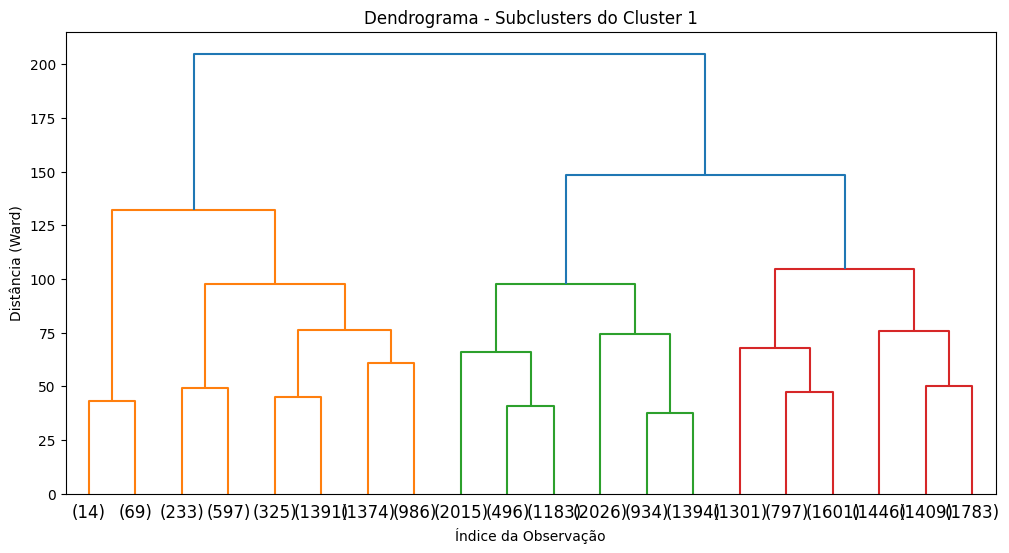

Subclusters gerados: (array([0, 1, 2]), array([8337, 8048, 4989]))


In [ ]:

from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from sklearn.metrics import silhouette_samples, silhouette_score


Z = linkage(cluster4_scaled, method='ward')  # método 'ward' minimiza a variância intra-cluster


plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='lastp', p=20, show_leaf_counts=True)
plt.title("Dendrograma - Subclusters do Cluster 1")
plt.xlabel("Índice da Observação")
plt.ylabel("Distância (Ward)")
plt.show()


subclusters = cut_tree(Z, n_clusters=3).flatten()
print("Subclusters gerados:", np.unique(subclusters, return_counts=True))


cluster4['subcluster'] = subclusters

In [ ]:
colunas_novas = {
    "monthly_income_usd": "Renda Mensal (USD)",
    "loan_amount_usd": "Valor Empréstimo (USD)",
    "debt_to_income_ratio": "Razão Dívida/Renda",
    "credit_score": "Score de Crédito",
    "savings_usd": "Economias (USD)",
    "savings_to_income_ratio": "Proporção Economia/Renda Anual",
    "monthly_expenses_usd": "Gastos Mensais (USD)",
    "loan_interest_rate_pct": "Taxa Juros (%)",
    "monthly_emi_usd": "Prestação Mensal (USD)",
    "loan_term_months": "Prazo Empréstimo (meses)",
    "age": "Idade",
    "gender": "Gênero",
    "education_level": "Escolaridade",
    "employment_status": "Situação Emprego",
    "job_title": "Cargo",
    "loan_type": "Tipo de Empréstimo",
    "region": "Região"
}


cluster4.rename(columns=colunas_novas, inplace=True)

def format_value(x):
    if isinstance(x, (int, float)):
        if abs(x) >= 1000:
            return f"{x:,.0f}"
        elif 0 < abs(x) < 1:
            return f"{x:.2%}" if '%' in str(x) else f"{x:.4f}"
        else:
            return f"{x:.2f}"
    return x


writer = pd.ExcelWriter('perfis_subcluster_cluster1.xlsx', engine='openpyxl')

cluster4.to_excel(writer, sheet_name='Dados Completos', index=False)


perfis = {}
for cluster_id, grupo in cluster4.groupby("subcluster"):

    estatisticas = grupo.describe(include='number').transpose()[['mean', 'std', 'min', 'max', '50%']]
    estatisticas.rename(columns={'50%': 'mediana'}, inplace=True)
    estatisticas = estatisticas.applymap(format_value)


    categoricas = pd.DataFrame()
    for col in ["Gênero", "Escolaridade", "Situação Emprego", "Cargo", "Tipo de Empréstimo", "Região"]:
        if col in grupo.columns:
            temp = grupo[col].value_counts(normalize=True).reset_index()
            temp.columns = [col, 'Proporção']
            temp['Proporção'] = temp['Proporção'].apply(lambda x: f"{x:.1%}")
            categoricas = pd.concat([categoricas, temp], axis=0)


    insights_data = {
        "Métrica": [
            "Média de renda",
            "Score de crédito médio",
            "Razão dívida/renda média",
            "% com empréstimo",
            "Idade média",
            "Proporção Economia/Renda média"
        ],
        "Valor": [
            f"${grupo['Renda Mensal (USD)'].mean():,.2f}",
            f"{grupo['Score de Crédito'].mean():.0f}",
            f"{grupo['Razão Dívida/Renda'].mean():.2f}",
            f"{grupo['Tipo de Empréstimo'].notna().mean()*100:.1f}%",
            f"{grupo['Idade'].mean():.1f} anos",
            f"{grupo['Proporção Economia/Renda Anual'].mean():.2f}"
        ]
    }
    insights_df = pd.DataFrame(insights_data)


    sheet_name = f'Cluster_{cluster_id}'

 
    estatisticas.to_excel(writer, sheet_name=sheet_name, startrow=1)
    categoricas.to_excel(writer, sheet_name=sheet_name, startrow=len(estatisticas)+4)
    insights_df.to_excel(writer, sheet_name=sheet_name, startrow=len(estatisticas)+len(categoricas)+8)


    workbook = writer.book
    worksheet = writer.sheets[sheet_name]

   
    worksheet['A1'] = f"Perfil do Cluster {cluster_id} - Estatísticas Numéricas"
    worksheet['A1'].font = Font(bold=True, size=14)

    start_cat = len(estatisticas) + 5
    worksheet[f'A{start_cat}'] = "Distribuições Categóricas"
    worksheet[f'A{start_cat}'].font = Font(bold=True, size=14)

    start_ins = len(estatisticas) + len(categoricas) + 9
    worksheet[f'A{start_ins}'] = "Principais Insights"
    worksheet[f'A{start_ins}'].font = Font(bold=True, size=14)


    for column in worksheet.columns:
        max_length = 0
        column_letter = column[0].column_letter
        for cell in column:
            try:
                if len(str(cell.value)) > max_length:
                    max_length = len(str(cell.value))
            except:
                pass
        adjusted_width = (max_length + 2) * 1.2
        worksheet.column_dimensions[column_letter].width = adjusted_width


    for row in worksheet.iter_rows():
        for cell in row:
            cell.alignment = Alignment(horizontal='left', vertical='center')


    perfis[cluster_id] = {
        'estatisticas': estatisticas,
        'categoricas': categoricas,
        'insights': insights_df
    }


writer.close()



/tmp/ipython-input-2830835501.py:47: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  estatisticas = estatisticas.applymap(format_value)
/tmp/ipython-input-2830835501.py:47: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  estatisticas = estatisticas.applymap(format_value)
/tmp/ipython-input-2830835501.py:47: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  estatisticas = estatisticas.applymap(format_value)


Subclusters do Cluster 1

Subcluster 0 – “Ricos de Baixa Reputação de Crédito”
Renda e economias muito altas, dívida mínima, mas score de crédito baixo (~456). Possivelmente por histórico negativo antigo ou pouco uso de crédito formal.

Subcluster 1 – “Modelo de Solidez Financeira”
Renda moderada, dívida baixa, economias robustas e score de crédito excelente (~706). Perfil mais saudável de todo o Cluster 1.

Subcluster 2 – “Altamente Endividados e Vulneráveis”
Renda mais baixa, dívida muito alta (4,39), quase todos com dívidas de alto risco e crises de pagamento. Economia reduzida para o padrão do cluster. Perfil de atenção máxima.

O Subcluster 2 é um “bolso de risco” dentro de um grupo financeiramente saudável. A renda e as economias ainda os colocam no Cluster 1, mas o comportamento de endividamento os diferencia fortemente.

# Analise de Outliers

In [ ]:
outliers = df[df['cluster_hier'] == -1]

print("Número de outliers:", len(outliers))
print("\nEstatísticas descritivas:")
print(outliers.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]).transpose())

Número de outliers: 4659

Estatísticas descritivas:
                          count           mean            std     min  \
age                      4659.0      43.800172      15.004228   18.00   
monthly_income_usd       4659.0    4029.617010    1915.107048  500.00   
monthly_expenses_usd     4659.0    2411.996813    1392.094814  150.26   
savings_usd              4659.0  246287.617227  194879.042175  992.52   
loan_amount_usd          4659.0   98845.280225  151366.934036    0.00   
loan_term_months         4659.0      58.470058     104.194626    0.00   
monthly_emi_usd          4659.0    3026.833612    6406.773166    0.00   
loan_interest_rate_pct   4659.0       6.581990       9.414039    0.00   
debt_to_income_ratio     4659.0       1.161910       3.523845    0.00   
credit_score             4659.0     572.893539     157.979643  300.00   
savings_to_income_ratio  4659.0       5.066613       2.858431    0.10   
high_risk_debt           4659.0       0.330114       0.470304    0.00   

In [ ]:

from openpyxl.styles import PatternFill, Font, Alignment
from openpyxl.utils import get_column_letter

conditions = [
    (outliers['high_risk_debt'] > 0.9) & (outliers['credit_score'] < 300),
    (outliers['savings_alert'] == 1),
    (outliers['debt_to_income_ratio'] > 10)
]
choices = ['Risco Extremo', 'Sem Reservas', 'Superendividado']
outliers['tipo_outlier'] = np.select(conditions, choices, default='Outro')


resumo_outliers = pd.DataFrame({
    'Contagem': outliers['tipo_outlier'].value_counts(),
    'Porcentagem': outliers['tipo_outlier'].value_counts(normalize=True).round(3) * 100
})


with pd.ExcelWriter('Analise_Outliers.xlsx', engine='openpyxl') as writer:

    outliers.to_excel(writer, sheet_name='Dados Completos', index=False)
    resumo_outliers.to_excel(writer, sheet_name='Resumo Categorias')

    for categoria in outliers['tipo_outlier'].unique():
        df_categoria = outliers[outliers['tipo_outlier'] == categoria]
        df_categoria.to_excel(writer, sheet_name=categoria[:31], index=False)  # Limite de 31 chars

    workbook = writer.book

    color_map = {
        'Risco Extremo': 'FF0000',  # Vermelho
        'Sem Reservas': 'FFA500',   # Laranja
        'Superendividado': 'FFFF00', # Amarelo
        'Outro': 'D3D3D3'          # Cinza
    }

    for sheet in workbook.sheetnames:
        ws = workbook[sheet]

        for col in ws.columns:
            max_length = 0
            column = col[0].column_letter
            for cell in col:
                try:
                    if len(str(cell.value)) > max_length:
                        max_length = len(str(cell.value))
                except:
                    pass
            adjusted_width = (max_length + 2) * 1.2
            ws.column_dimensions[column].width = adjusted_width

        if sheet == 'Dados Completos':
            for row in ws.iter_rows(min_row=2, max_row=ws.max_row, min_col=outliers.columns.get_loc('tipo_outlier')+1):
                for cell in row:
                    if cell.value in color_map:
                        cell.fill = PatternFill(start_color=color_map[cell.value],
                                              end_color=color_map[cell.value],
                                              fill_type='solid')

        for cell in ws[1]:
            cell.font = Font(bold=True)
            cell.alignment = Alignment(horizontal='center')

print("\n=== Distribuição de Outliers por Categoria ===")
print(resumo_outliers)
print("\n=== Características Principais ===")
print("Total de outliers:", len(outliers))
print("Principais categorias:")
for cat, count in outliers['tipo_outlier'].value_counts().items():
    print(f"- {cat}: {count} casos ({count/len(outliers):.1%})")

print("\n✅ Arquivo 'analise_outliers.xlsx' exportado com sucesso!")
print("💡 Sugestão: Analisar especialmente os casos de 'Risco Extremo' e 'Superendividado'")

/tmp/ipython-input-1653199513.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers['tipo_outlier'] = np.select(conditions, choices, default='Outro')



=== Distribuição de Outliers por Categoria ===
                 Contagem  Porcentagem
tipo_outlier                          
Outro                4523         97.1
Superendividado       102          2.2
Sem Reservas           34          0.7

=== Características Principais ===
Total de outliers: 4659
Principais categorias:
- Outro: 4523 casos (97.1%)
- Superendividado: 102 casos (2.2%)
- Sem Reservas: 34 casos (0.7%)

✅ Arquivo 'Analise_Outliers.xlsx' exportado com sucesso!
💡 Sugestão: Analisar especialmente os casos de 'Risco Extremo' e 'Superendividado'


Perfis dos Outliers

Outro – “Fora da Curva Estável”
Fora do padrão dos clusters, mas com alta renda e reservas financeiras. Dívida moderada e risco controlado, apesar de não se encaixar no perfil médio.

Sem Reservas – “Viver no Limite”
Boa renda, mas praticamente sem poupança. Um imprevisto pode causar instabilidade financeira mesmo com bom score de crédito.

Superendividado – “Colapso Financeiro”
Renda muito baixa, dívida desproporcionalmente alta (19,25), 100% com dívidas de alto risco e em crise de pagamento. Perfil crítico e insustentável.